In [3]:
import time
from tqdm.notebook import trange, tqdm
from functools import partial
trange = partial(trange, bar_format="{bar}", leave=False)
tqdm = partial(tqdm, bar_format="{bar}", leave=False)

import jax
import jax.numpy as jnp
from jax import grad, vmap
from jax import random

# Set random seed for reproducibility
_key = jax.random.key(42)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
%matplotlib inline
# %config InlineBackend.figure_format='svg'
%config InlineBackend.figure_format='retina'
%load_ext vscode_magic
import seaborn as sns

import numpy as np
from scipy.stats import gaussian_kde

The vscode_magic extension is already loaded. To reload it, use:
  %reload_ext vscode_magic


In [4]:
import time
from tqdm.notebook import trange, tqdm

for i in trange(10, leave=True,
                #  bar_format="{bar}"
                 ):
    time.sleep(0.1)


  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# "iridis" color map (viridis without the deep purple)
import matplotlib.colors as colors
import matplotlib.cm

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

iridis = truncate_colormap(plt.get_cmap('viridis'), 0.2, 1)

In [6]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
.progress-bar {
   height: 20px !important;
}
</style>

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import matplotlib.pyplot as plt
from functools import partial

# Define target distribution (multivariate Gaussian in this case)
def log_prob(x):
    """Log probability of a 2D Gaussian with correlation"""
    mu = jnp.array([0.0, 0.0])
    sigma = jnp.array([[1.0, 0.8], 
                       [0.8, 2.0]])
    inv_sigma = jnp.linalg.inv(sigma)
    delta = x - mu
    return -0.5 * jnp.dot(delta, jnp.dot(inv_sigma, delta)) - 0.5 * jnp.log(jnp.linalg.det(sigma)) - jnp.log(2 * jnp.pi)

# Define the kernel function (RBF)
def rbf_kernel(x, y, h=None):
    """
    RBF kernel with automatic bandwidth selection if h is None
    """
    delta = x - y
    sq_dist = jnp.sum(delta ** 2)
    
    if h is None:
        # Median heuristic for bandwidth
        h = 0.5  # Fixed for this example, but could be computed from particles
    
    return jnp.exp(-sq_dist / h)

# Define kernel gradient
grad_kernel = jax.grad(rbf_kernel, argnums=0)

# SVGD update step
def svgd_update(particles, log_prob_fn, kernel_fn, step_size):
    """
    Compute SVGD update for all particles
    """
    n_particles = particles.shape[0]
    
    # Compute score function (gradient of log probability)
    score_fn = jax.grad(log_prob_fn)
    
    # Vectorize score function over particles
    scores = vmap(score_fn)(particles)
    
    # Compute kernel matrix and its gradient
    def kernel_matrix_row(particle_i):
        # Compute kernel values between particle_i and all particles
        kernel_values = vmap(lambda particle_j: kernel_fn(particle_i, particle_j))(particles)
        
        # Compute kernel gradients between particle_i and all particles
        kernel_grads = vmap(lambda particle_j: grad_kernel(particle_i, particle_j))(particles)
        
        return kernel_values, kernel_grads
    
    # Vectorize over all particles
    kernel_matrix_and_grads = vmap(kernel_matrix_row)(particles)
    kernel_matrix = kernel_matrix_and_grads[0]  # Shape: [n_particles, n_particles]
    kernel_grads = kernel_matrix_and_grads[1]   # Shape: [n_particles, n_particles, dim]
    
    # Compute the SVGD update
    def particle_update(particle_idx):
        # First term: weighted score function
        # weighted_scores = kernel_matrix[particle_idx] * scores
        weighted_scores = (kernel_matrix[particle_idx] * scores.T).T
        term1 = jnp.sum(weighted_scores, axis=0) / n_particles
        
        # Second term: kernel gradient term
        term2 = jnp.sum(kernel_grads[particle_idx], axis=0) / n_particles
        
        return term1 + term2
    
    # Compute updates for all particles
    updates = vmap(particle_update)(jnp.arange(n_particles))
    
    # Apply updates to particles
    new_particles = particles + step_size * updates
    
    return new_particles

# # JIT-compile the update function for efficiency
# svgd_update_jit = jit(svgd_update, static_argnums=(2,))

# Initialize particles from a standard Gaussian
n_particles = 100
dim = 2
key, subkey = jax.random.split(_key)
initial_particles = jax.random.normal(subkey, shape=(n_particles, dim)) * 3

# Run SVGD
n_iter = 300
step_size = 0.05
particles = initial_particles

for i in trange(n_iter):
    # particles = svgd_update_jit(particles, log_prob, rbf_kernel, step_size)
    particles = svgd_update(particles, log_prob, rbf_kernel, step_size)
    # if i % 100 == 0:
    #     print(f"Iteration {i}")

# Visualize results
plt.figure(figsize=(7, 5))

# Plot final particles
plt.scatter(particles[:, 0], particles[:, 1], s=10, alpha=0.6, edgecolor='none', label='SVGD particles')

# Generate contour plot of the target distribution
x = jnp.linspace(-4, 4, 100)
y = jnp.linspace(-4, 4, 100)
X, Y = jnp.meshgrid(x, y)
pos = jnp.stack([X.flatten(), Y.flatten()], axis=1)
Z = jnp.exp(vmap(log_prob)(pos)).reshape(X.shape)

plt.contour(X, Y, Z, cmap=iridis, alpha=0.7)
#plt.title('SVGD with JAX: Sampling from a 2D Gaussian')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
# plt.grid(alpha=0.3)
plt.colorbar(label='Probability Density')
plt.show()


  0%|          | 0/300 [00:00<?, ?it/s]

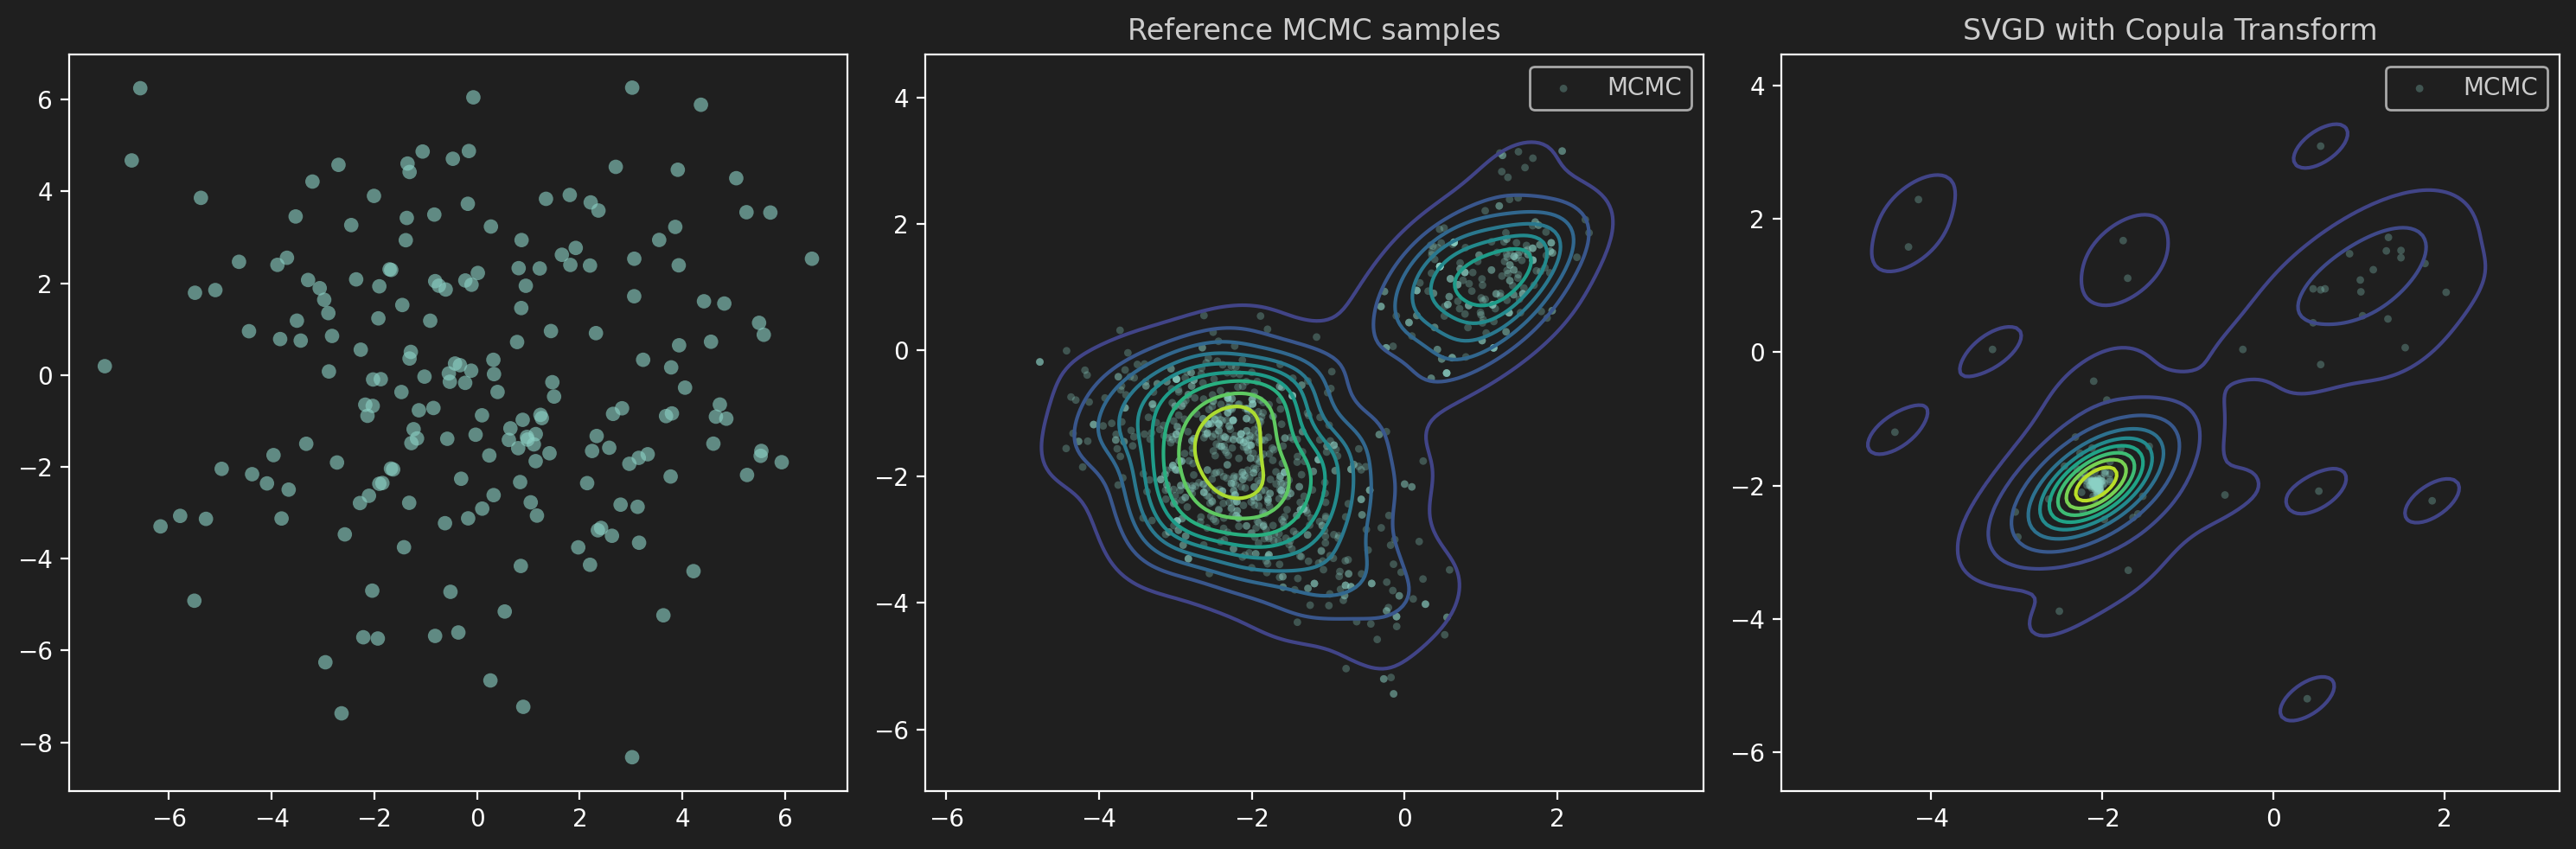

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# # Set random seed
# key = jax.random.PRNGKey(42)

# Define a skewed target distribution (mixture of Gaussians)
def target_log_prob(x):
    """
    Log probability of a skewed distribution (mixture of Gaussians)
    """
    # First component: centered at (1, 1) with small variance
    mean1 = jnp.array([1.0, 1.0])
    sigma1 = jnp.array([[0.3, 0.1], [0.1, 0.3]])
    inv_sigma1 = jnp.linalg.inv(sigma1)
    delta1 = x - mean1
    log_prob1 = -0.5 * jnp.dot(delta1, jnp.dot(inv_sigma1, delta1)) - jnp.log(jnp.sqrt(jnp.linalg.det(sigma1)))
    
    # Second component: centered at (-2, -2) with larger variance
    mean2 = jnp.array([-2.0, -2.0])
    sigma2 = jnp.array([[1.0, -0.5], [-0.5, 1.0]])
    inv_sigma2 = jnp.linalg.inv(sigma2)
    delta2 = x - mean2
    log_prob2 = -0.5 * jnp.dot(delta2, jnp.dot(inv_sigma2, delta2)) - jnp.log(jnp.sqrt(jnp.linalg.det(sigma2)))
    
    # Mixture weights (0.7 for component 1, 0.3 for component 2)
    return jnp.log(0.7 * jnp.exp(log_prob1) + 0.3 * jnp.exp(log_prob2))

# Kernel function for SVGD
def rbf_kernel(x, y, h=None):
    """RBF kernel with median heuristic for bandwidth"""
    delta = x - y
    sq_dist = jnp.sum(delta ** 2)
    
    if h is None:
        h = 1.0  # Fixed bandwidth for simplicity
    
    return jnp.exp(-sq_dist / h)

# SVGD update (similar to previous example)
# @jit
def svgd_update(particles, log_prob_fn, kernel_fn, step_size):
    """SVGD update for particle-based sampling"""
    n_particles = particles.shape[0]
    
    # Score function
    scores = vmap(grad(log_prob_fn))(particles)
    
    # Pairwise distances and kernel evaluations
    def kernel_and_grad(x_i):
        kxy = vmap(lambda x_j: kernel_fn(x_i, x_j))(particles)
        kxy_grad = vmap(lambda x_j: grad(lambda x: kernel_fn(x, x_j))(x_i))(particles)
        return kxy, kxy_grad
    
    kernel_results = vmap(kernel_and_grad)(particles)
    kxy = kernel_results[0]  # n_particles x n_particles
    kxy_grad = kernel_results[1]  # n_particles x n_particles x dim
    
    # SVGD update formula
    weighted_score = jnp.matmul(kxy, scores) / n_particles
    weighted_grad = jnp.sum(kxy_grad, axis=1) / n_particles
    
    return particles + step_size * (weighted_score + weighted_grad)

# Copula transformation functions
def empirical_cdf(x, particles):
    """Compute empirical CDF at point x for a given dimension"""
    return jnp.mean(particles <= x)

def normal_cdf(x):
    """Standard normal CDF"""
    return 0.5 * (1 + jax.scipy.special.erf(x / jnp.sqrt(2.0)))

def normal_ppf(u):
    """Inverse of standard normal CDF (percent point function)"""
    # Using approximation for simplicity in JAX
    return jnp.sqrt(2.0) * jax.lax.erf_inv(2.0 * u - 1.0)

# # Transformation to Gaussian copula space
# def copula_transform(particles):
#     """Transform particles to Gaussian copula space"""
#     n_particles, dim = particles.shape
#     transformed = jnp.zeros_like(particles)
    
#     for d in range(dim):
#         # Compute empirical CDF values for each particle in this dimension
#         ecdf_values = jnp.array([empirical_cdf(particles[i, d], particles[:, d]) 
#                                for i in range(n_particles)])
        
#         # Apply inverse normal CDF to get Gaussian copula space
#         # Add small epsilon to avoid boundary issues
#         epsilon = 1e-8
#         u_values = jnp.clip(ecdf_values, epsilon, 1.0 - epsilon)
#         transformed = transformed.at[:, d].set(normal_ppf(u_values))
    
#     return transformed

# More robust copula transformation
def copula_transform(particles):
    """Transform particles to Gaussian copula space with better numerical stability"""
    n_particles, dim = particles.shape
    transformed = jnp.zeros_like(particles)
    
    for d in range(dim):
        # Sort particles in this dimension
        sorted_particles = jnp.sort(particles[:, d])
        
        # Get ranks (with averaging for ties)
        ranks = jnp.zeros(n_particles)
        for i in range(n_particles):
            # Count particles less than or equal to the current one
            ranks = ranks.at[i].set(jnp.sum((particles[:, d] <= particles[i, d]).astype(float)))
        
        # Convert ranks to [0,1] interval with endpoints adjustment
        # Use (rank - 0.5)/n instead of rank/n to avoid 0 and 1
        u_values = (ranks - 0.5) / n_particles
        u_values = jnp.clip(u_values, 0.001, 0.999)  # More conservative clipping
        
        # Transform to normal
        transformed = transformed.at[:, d].set(normal_ppf(u_values))
    
    return transformed

# # Inverse transform back to original space
# def inverse_copula_transform(transformed_particles, reference_particles):
#     """Transform particles from Gaussian copula space back to original space"""
#     n_particles, dim = transformed_particles.shape
#     original_space = jnp.zeros_like(transformed_particles)
    
#     for d in range(dim):
#         # Convert to uniform via normal CDF
#         u_values = normal_cdf(transformed_particles[:, d])
        
#         # Use empirical quantile function to map back to original space
#         sorted_ref = jnp.sort(reference_particles[:, d])
#         indices = jnp.floor(u_values * n_particles).astype(int)
#         indices = jnp.clip(indices, 0, n_particles - 1)
#         original_space = original_space.at[:, d].set(sorted_ref[indices])
    
#     return original_space

# Improved inverse transform
def inverse_copula_transform(transformed_particles, reference_particles):
    """Transform particles from Gaussian copula space back to original space with interpolation"""
    n_particles, dim = transformed_particles.shape
    n_ref = reference_particles.shape[0]
    original_space = jnp.zeros_like(transformed_particles)
    
    for d in range(dim):
        # Convert to uniform via normal CDF
        u_values = normal_cdf(transformed_particles[:, d])
        
        # Use continuous interpolation instead of discrete indices
        sorted_ref = jnp.sort(reference_particles[:, d])
        
        # Linear interpolation between points
        continuous_indices = u_values * (n_ref - 1)
        lower_indices = jnp.floor(continuous_indices).astype(int)
        upper_indices = jnp.ceil(continuous_indices).astype(int)
        
        # Clip to valid range
        lower_indices = jnp.clip(lower_indices, 0, n_ref - 1)
        upper_indices = jnp.clip(upper_indices, 0, n_ref - 1)
        
        # Get values and interpolate
        lower_values = sorted_ref[lower_indices]
        upper_values = sorted_ref[upper_indices]
        
        # Weight for interpolation
        weights = continuous_indices - lower_indices
        
        # Interpolate
        interpolated = lower_values + weights * (upper_values - lower_values)
        original_space = original_space.at[:, d].set(interpolated)
    
    return original_space

# Main function to run SVGD with copula transformation
def run_copula_svgd():
    # Generate initial samples from the target to use for reference
    n_particles = 200
    dim = 2
    
    # Initialize particles from a wide Gaussian for exploration
    key, subkey = jax.random.split(_key)
    initial_particles = jax.random.normal(subkey, shape=(n_particles, dim)) * 3.0
    
    # Generate samples from target for reference
    n_mcmc = 1000
    mcmc_samples = jnp.zeros((n_mcmc, dim))
    current = jnp.zeros(dim)
    
    # Simple Metropolis-Hastings to get reference samples
    for i in trange(n_mcmc + 500):  # 500 burn-in
        key, subkey = jax.random.split(key)
        proposal = current + jax.random.normal(subkey, shape=(dim,)) * 0.5
        
        accept_prob = jnp.exp(target_log_prob(proposal) - target_log_prob(current))
        key, subkey = jax.random.split(key)
        if jax.random.uniform(subkey) < accept_prob:
            current = proposal
            
        if i >= 500:
            mcmc_samples = mcmc_samples.at[i-500].set(current)
    
    # Run SVGD in copula-transformed space
    # Transform initial particles to copula space
    copula_particles = copula_transform(initial_particles)
    
    # Define log-probability in copula space
    def copula_log_prob(x):
        """Log probability in the copula space"""
        # Map from copula space to original space
        original_x = inverse_copula_transform(x.reshape(1, -1), mcmc_samples).flatten()
        # Evaluate log probability in original space
        return target_log_prob(original_x)
    
    # Run SVGD in copula space
    n_iter = 300
    step_size = 0.01
    particles = copula_particles
    
    for i in trange(n_iter):
        particles = svgd_update(particles, copula_log_prob, rbf_kernel, step_size)
        # if i % 100 == 0:
        #     print(f"Iteration {i}")
    
    # Transform back to original space
    final_particles = inverse_copula_transform(particles, mcmc_samples)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot initial particles
    plt.subplot(1, 3, 1)
    plt.scatter(initial_particles[:, 0], initial_particles[:, 1], edgecolor='none', alpha=0.6, label='Initial')
    # plt.grid(alpha=0.3)
    
    # Plot reference samples
    plt.subplot(1, 3, 2)
    # plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], edgecolor='none', alpha=0.3, s=10, label='MCMC')
    sns.scatterplot(x=mcmc_samples[:, 0], y=mcmc_samples[:, 1], edgecolor='none', alpha=0.3, s=10, label='MCMC')
    sns.kdeplot(x=mcmc_samples[:, 0], y=mcmc_samples[:, 1], cmap=iridis)    
    plt.title('Initial particles')
    plt.title('Reference MCMC samples')
    # plt.grid(alpha=0.3)
    
    # Plot final SVGD particles
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=final_particles[:, 0], y=final_particles[:, 1], edgecolor='none', alpha=0.3, s=10, label='MCMC')
    sns.kdeplot(x=final_particles[:, 0], y=final_particles[:, 1], cmap=iridis)    
    # plt.scatter(final_particles[:, 0], final_particles[:, 1], edgecolor='none', alpha=0.6, label='SVGD')
    plt.title('SVGD with Copula Transform')
    # plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return final_particles, mcmc_samples

# Run the example
final_particles, reference_samples = run_copula_svgd()

In [ ]:
def map_estimate_from_particles(particles, log_prob_fn):
    """
    Find the MAP estimate from a set of particles by finding the particle
    with the highest log probability.
    
    Args:
        particles: Array of shape (n_particles, dim)
        log_prob_fn: Function that computes log probability
    
    Returns:
        The particle with highest log probability
    """
    n_particles = particles.shape[0]
    
    # Compute log probability for each particle
    log_probs = jnp.array([log_prob_fn(particles[i]) for i in range(n_particles)])
    
    # Find the particle with the highest log probability
    map_idx = jnp.argmax(log_probs)
    
    return particles[map_idx], log_probs[map_idx]


def map_estimate_with_optimization(particles, log_prob_fn, n_steps=100, step_size=0.01):
    """
    Refine MAP estimate by starting from the best particle and performing
    gradient ascent on the log probability.
    
    Args:
        particles: Array of shape (n_particles, dim)
        log_prob_fn: Function that computes log probability
        n_steps: Number of optimization steps
        step_size: Step size for gradient ascent
    
    Returns:
        The refined MAP estimate after optimization
    """
    # Start with the best particle
    map_particle, _ = map_estimate_from_particles(particles, log_prob_fn)
    
    # Define gradient of log probability
    grad_log_prob = jax.grad(log_prob_fn)
    
    # Perform gradient ascent to refine the MAP estimate
    x = map_particle
    for _ in range(n_steps):
        grad = grad_log_prob(x)
        x = x + step_size * grad
    
    return x, log_prob_fn(x)


In [ ]:
def estimate_hdr(particles, log_prob_fn, alpha=0.95):
    """
    Estimate the Highest Density Region (HDR) from particles.
    
    Args:
        particles: Array of shape (n_particles, dim)
        log_prob_fn: Function that computes log probability
        alpha: Coverage probability (e.g., 0.95 for 95% HDR)
    
    Returns:
        List of particles that are within the HDR
        The log probability threshold that defines the HDR
    """
    n_particles = particles.shape[0]
    
    # Compute log probability for each particle
    log_probs = jnp.array([log_prob_fn(particles[i]) for i in range(n_particles)])
    
    # Sort particles by log probability (descending)
    sorted_indices = jnp.argsort(-log_probs)
    sorted_log_probs = log_probs[sorted_indices]
    
    # Find the log probability threshold for the HDR
    n_hdr = int(n_particles * alpha)
    threshold = sorted_log_probs[n_hdr-1]
    
    # Get particles in the HDR
    hdr_mask = log_probs >= threshold
    hdr_particles = particles[hdr_mask]
    
    return hdr_particles, threshold


def visualize_hdr_2d(particles, log_prob_fn, alphas=[0.95], grid_size=100, xlim=None, ylim=None):
    """
    Visualize the Highest Density Region (HDR) for a 2D distribution.
    
    Args:
        particles: Array of shape (n_particles, 2)
        log_prob_fn: Function that computes log probability
        alpha: Coverage probability (e.g., 0.95 for 95% HDR)
        grid_size: Size of the grid for visualization
        xlim, ylim: Limits for the grid
    
    Returns:
        Figure with HDR visualization
    """
    if particles.shape[1] != 2:
        raise ValueError("This function only works for 2D distributions")
    
    # Determine limits if not provided
    if xlim is None:
        x_min, x_max = particles[:, 0].min(), particles[:, 0].max()
        margin = (x_max - x_min) * 0.1
        xlim = (x_min - margin, x_max + margin)
    
    if ylim is None:
        y_min, y_max = particles[:, 1].min(), particles[:, 1].max()
        margin = (y_max - y_min) * 0.1
        ylim = (y_min - margin, y_max + margin)
    
    # Create grid
    x = jnp.linspace(xlim[0], xlim[1], grid_size)
    y = jnp.linspace(ylim[0], ylim[1], grid_size)
    X, Y = jnp.meshgrid(x, y)
    
    # Evaluate log probability on grid
    Z = jnp.zeros_like(X)
    for i in trange(grid_size):
        for j in range(grid_size):
            Z = Z.at[i, j].set(log_prob_fn(jnp.array([X[i, j], Y[i, j]])))
    
    # Get HDR threshold
    levels = []
    for alpha in alphas:
        _, threshold = estimate_hdr(particles, log_prob_fn, alpha)
        levels.append(threshold)
    levels = sorted(levels)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Plot contour for HDR
    contour = ax.contour(X, Y, Z, levels=levels, cmap=iridis, linestyles='dashed')
    # ax.clabel(contour, inline=True, fontsize=10, fmt=f'{alpha*100:.0f}% HDR')
    ax.clabel(contour, inline=True, fontsize=10, fmt=f'{alpha:.2f}')
    
    # # Fill HDR region
    # filled = ax.contourf(X, Y, Z, levels=[threshold, jnp.max(Z)], alpha=0.3, cmap='Reds')
    
    # Plot particles
    # ax.scatter(particles[:, 0], particles[:, 1], alpha=0.5, c='blue', s=10)
    sns.scatterplot(x=particles[:, 0], y=particles[:, 1], edgecolor='none', alpha=0.3, s=10)

    # Find and mark MAP estimate
    map_particle, _ = map_estimate_from_particles(particles, log_prob_fn)
    ax.scatter(map_particle[0], map_particle[1], color='red', s=100, marker='*', 
               label='MAP estimate')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title(f'Highest Density Region ({alpha*100:.0f}%)')
    ax.legend()
    # ax.grid(alpha=0.3)
    
    return fig


MAP estimate: [1.0125928 1.08084  ], log probability: 0.8949111104011536
Refined MAP: [1.0035124 1.0039167], log probability: 0.9061545133590698
HDR contains 190 particles out of 200
HDR log probability threshold: -3.1866455078125


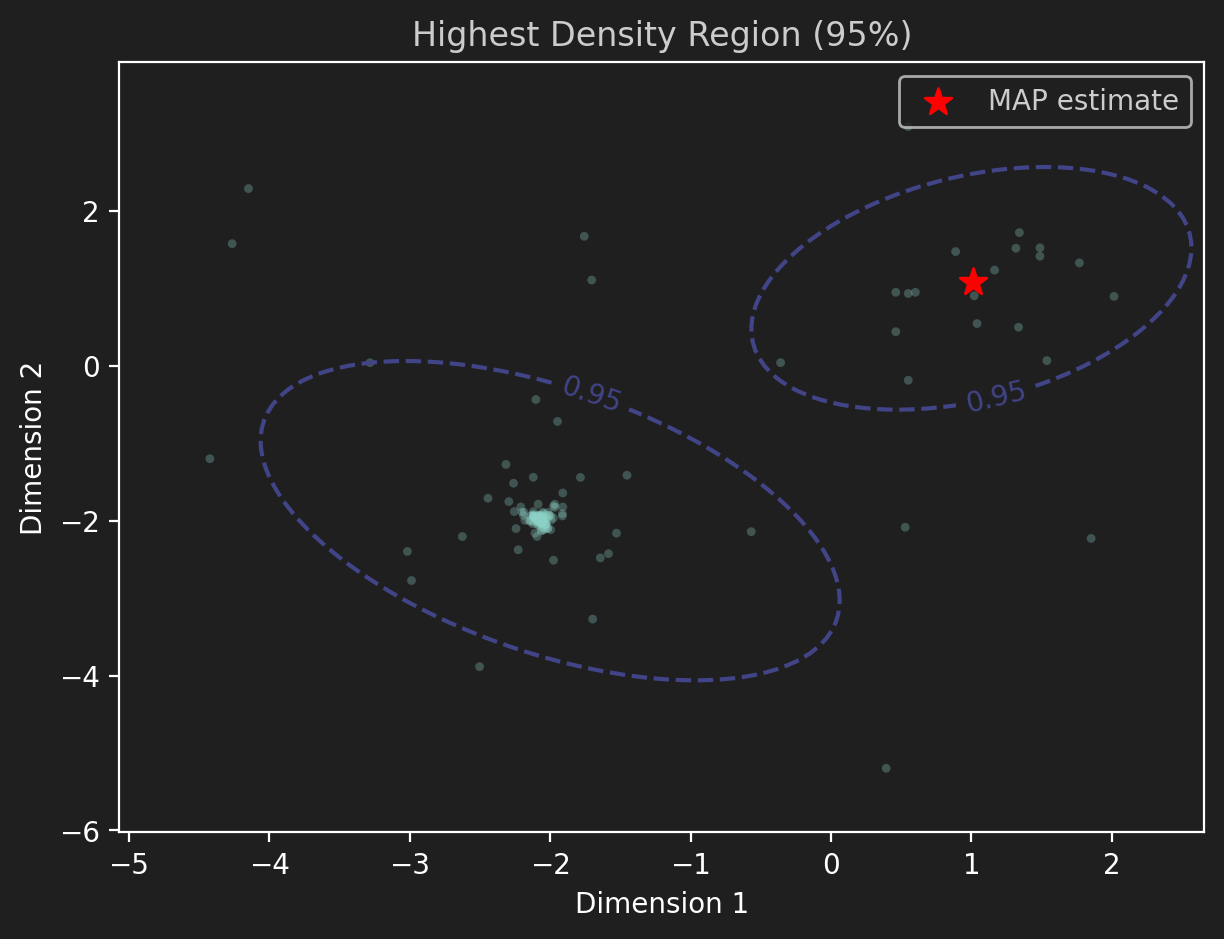

In [ ]:
# After running SVGD to get particles
particles = final_particles  # From the SVGD run

# Find MAP estimate
map_point, map_log_prob = map_estimate_from_particles(particles, target_log_prob)
print(f"MAP estimate: {map_point}, log probability: {map_log_prob}")

# Refine with optimization
refined_map, refined_log_prob = map_estimate_with_optimization(particles, target_log_prob)
print(f"Refined MAP: {refined_map}, log probability: {refined_log_prob}")

# Get HDR
hdr_particles, threshold = estimate_hdr(particles, target_log_prob, alpha=0.95)
print(f"HDR contains {len(hdr_particles)} particles out of {len(particles)}")
print(f"HDR log probability threshold: {threshold}")

# Visualize HDR for 2D distribution
alphas=[
    # 0.8, 
    0.95, 
    # 0.99, 0.999
    ]
if particles.shape[1] == 2:
    fig = visualize_hdr_2d(particles, target_log_prob, alphas=alphas)
    plt.show()
